In [51]:
from IPython.display import display, HTML
display(HTML(""))
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import IFrame, display
from matplotlib import cm
import pandas as pd
import os.path as path
import os
import wget
from tqdm import tqdm
import corner

from scipy.integrate import dblquad

In [52]:
# Descargamos data
if not path.exists('Data'):
    os.mkdir('Data')

!rm Data/*

file = 'Data/Gaussiana.csv'
#url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/Gaussiano.csv'
url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/Chi2Fitting.txt'
#url = 'https://raw.githubusercontent.com/asegura4488/DataBase/main/MetodosComputacionales/Likelihood.dat'
if not path.exists(file):
    Path_ = wget.download(url,file)
    print('File loaded')
else:
    Path_ = file

100% [..................................................................................] 161 / 161File loaded


In [53]:
Data = pd.read_csv(Path_)

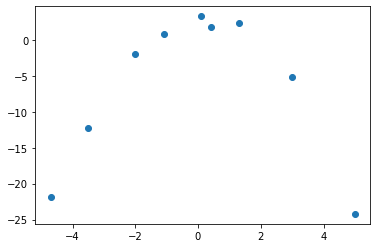

In [55]:
plt.scatter(Data.x,Data.y)

In [3]:
Data = pd.read_csv(Path_)
X = Data.x

#X = np.loadtxt(Path_)
len(X)

100

In [4]:
#plt.hist(X,bins=25);

In [5]:
def LogPrior(p):
    mu, sigma = p
    if 3 <= mu <= 5 and 0.5 <= sigma <= 3.5:
        return 0.
    else:
        return -np.inf

In [6]:
def Gaus(p,x):
    mu, sigma = p
    return np.exp( -0.5*( (x-mu)/sigma )**2 )/np.sqrt( 2*np.pi*sigma**2 )

In [7]:
def Likelihood(p,x):
    return Gaus(p,x)

In [8]:
#Likelihood([1,0.7],X)

In [9]:
def JointLikelihood(p,x):
    return np.sum(np.log(Likelihood(p,x)))

In [10]:
JointLikelihood([1,0.8],X)

-1034.5107206667983

In [11]:
def LogPosterior(p,x):
    LogP = LogPrior(p)
    
    if not np.isfinite(LogP):
        return -np.inf
    else:
        return JointLikelihood(p,x) + LogP

In [12]:
LogPosterior([3.5,0.8],X)

-345.0026107612527

In [42]:
def Metropolis(x0, Posterior, NSteps=int(1e4), delta=0.3):
    
    x = np.zeros((NSteps,len(x0)))
    x[0] = x0
    
    for i in tqdm(range(1,NSteps)):
        
        P0 = np.exp( Posterior(x[i-1],X) )
        
        xf = x[i-1] + delta*2*(np.random.rand(len(x0))-0.5)
        
        P1 = np.exp( Posterior(xf,X) )
        
        alpha = np.minimum(1,P1/P0)
        g = np.random.rand()

        if alpha > g:
            x[i,:] = xf
        else:
            x[i,:] = x[i-1,:]
            
    return x[100:,:]

In [43]:
initparams = np.array([5.0,1.0])
MCMC = Metropolis(initparams,LogPosterior)

100%|██████████████████████████████████████████████████████████| 9999/9999 [00:32<00:00, 306.46it/s]


In [44]:
mean = np.percentile(MCMC,50,axis=0)
mean

array([4.02810995, 1.83590291])

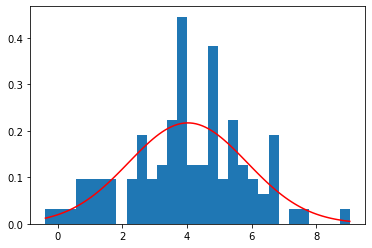

In [45]:
plt.hist(X,bins=30,density=True)
t = np.linspace(np.min(X),np.max(X),100)
plt.plot(t,Gaus(mean,t),color='r')

0
1


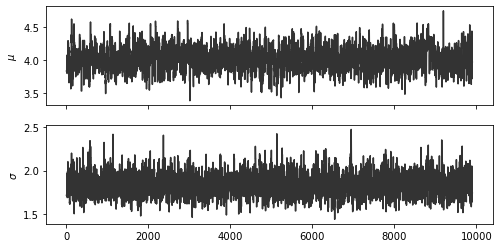

In [46]:
fig, axes = plt.subplots( len(initparams), figsize=(8,4), sharex=True )
labels=['$\mu$','$\sigma$']

for i in range(len(initparams)):
    print(i)
    ax = axes[i]
    ax.plot(MCMC[:,i],'k',alpha=0.8)
    ax.set_ylabel(labels[i])

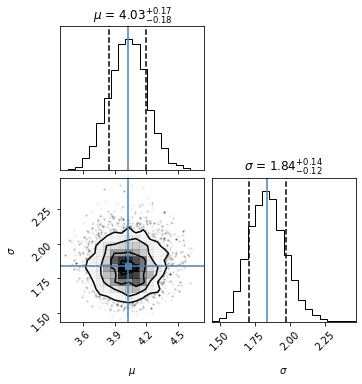

In [47]:
figure = corner.corner( MCMC, truths=mean, labels = labels, quantiles=[0.16,0.84], show_titles=True )